In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.backends import backend_pdf as bpdf
import matplotlib
import pickle
from scipy.special import kl_div
from scipy.optimize import brentq,minimize,LinearConstraint,Bounds,NonlinearConstraint
from scipy.integrate import solve_ivp
%matplotlib inline

# MacArthur's Models (Theor. Pop. Biol. 1, 1970)

## Competition for noninteracting resources

\begin{align}
\frac{dN_i}{dt} &= N_i \left[ \sum_{\alpha} w_\alpha c_{i\alpha} R_\alpha - m_i\right]\\
\frac{dR_\alpha}{dt} &= r_\alpha R_\alpha (R_\alpha^0 - R_\alpha) - \sum_i N_i c_{i\alpha} R_\alpha.
\end{align}

\begin{align}
d(\mathbf{R}^0,\mathbf{R}) &= \frac{1}{2}\sum_\alpha r_\alpha w_\alpha (R_\alpha - R_\alpha^0)^2\\
\sum_{\alpha} w_\alpha c_{i\alpha} R_\alpha &\leq m_i\\
R_\alpha &\geq 0
\end{align}

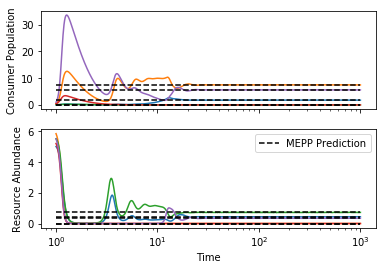

In [90]:
#Parameters
S = 5
M = 5
params = {'c':np.random.rand(S,M),
          'm':np.random.rand(S)+1,
          'w':np.random.rand(M)+1,
          'r':np.random.rand(M)+1,
          'R0':np.random.rand(M)+5}
N_init = np.random.rand(S)
R_init = params['R0']
tmin = 1
tmax= 1000

#ODE
def dydt(t,y):
    N = y[:S]
    R = y[S:]
    dNdt = N*((params['c']*params['w']).dot(R)-params['m'])
    dRdt = params['r']*R*(params['R0']-R) - (params['c'].T.dot(N))*R
    return np.hstack((dNdt,dRdt))
out_ODE = solve_ivp(dydt,(tmin,tmax),np.hstack((N_init,R_init)),t_eval=np.logspace(np.log10(tmin),np.log10(tmax),1000))
t = out_ODE.t
N = out_ODE.y[:S,:].T
R = out_ODE.y[S:,:].T

#Constrained optimization
noninvadable = LinearConstraint(params['c']*params['w'],-np.inf*np.ones(S),params['m'])
resource_feasible = Bounds(0,np.inf)
def d(R):
    return 0.5*((R-params['R0'])**2*params['w']*params['r']).sum()
out_opt = minimize(d, R_init, method='trust-constr', constraints=noninvadable, bounds=resource_feasible)
Rstar = out_opt.x
Nstar = out_opt.v[0]

fig,ax=plt.subplots(2,sharex=True)
#Plot ODE results
ax[0].semilogx(t,N)
ax[1].semilogx(t,R)
#Plot optimization results
ax[0].plot([t[0],t[-1]],[Nstar,Nstar],'k--')
ax[1].plot([t[0],t[-1]],[Rstar,Rstar],'k--')
#Make legend
ax[1].plot([],[],'k--',label='MEPP Prediction')
ax[1].legend()
#Make labels
ax[1].set_xlabel('Time')
ax[0].set_ylabel('Consumer Population')
ax[1].set_ylabel('Resource Abundance')
plt.show()

## Interacting self-regulation

\begin{align}
\frac{dN_i}{dt} &= N_i\left[ \sum_{\alpha} w_\alpha c_{i\alpha} R_\alpha - m_i\right]\\
\frac{dR_\alpha}{dt} &= R_\alpha\left(A - \sum_\beta w_\beta R_\beta \right) -  \sum_i c_{i\alpha} N_i R_\alpha.
\end{align}

\begin{align}
d(\mathbf{R}^0,\mathbf{R}) &=  \frac{1}{2}\left(A - \sum_{\alpha} w_\alpha R_\alpha \right)^2\\
\sum_{\alpha} w_\alpha c_{i\alpha} R_\alpha &\leq m_i\\
R_\alpha &\geq 0
\end{align}

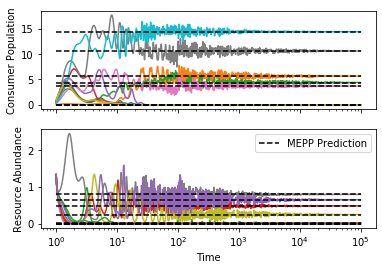

In [91]:
#Parameters
S = 10
M = 15
params = {'c':np.random.rand(S,M),
          'm':np.random.rand(S)+1,
          'w':np.random.rand(M)+1,
          'A':20}
N_init = np.random.rand(S)
R_init = np.ones(M)*params['A']/M
tmin = 1
tmax= 100000

#ODE
def dydt(t,y):
    N = y[:S]
    R = y[S:]
    dNdt = N*((params['c']*params['w']).dot(R)-params['m'])
    dRdt = R*(params['A']-params['w'].dot(R)) - (params['c'].T.dot(N)).T*R
    return np.hstack((dNdt,dRdt))
out_ODE = solve_ivp(dydt,(tmin,tmax),np.hstack((N_init,R_init)),t_eval=np.logspace(np.log10(tmin),np.log10(tmax),1000))
t = out_ODE.t
N = out_ODE.y[:S,:].T
R = out_ODE.y[S:,:].T

#Constrained optimization
noninvadable = LinearConstraint(params['c']*params['w'],-np.inf*np.ones(S),params['m'])
resource_feasible = Bounds(0,np.inf)
def d(R):
    return 0.5*(params['A'] - params['w'].dot(R))**2
out_opt = minimize(d, R_init, method='trust-constr', constraints=noninvadable, bounds=resource_feasible)
Rstar = out_opt.x
Nstar = out_opt.v[0]

fig,ax=plt.subplots(2,sharex=True)
#Plot ODE results
ax[0].semilogx(t,N)
ax[1].semilogx(t,R)
#Plot optimization results
ax[0].plot([t[0],t[-1]],[Nstar,Nstar],'k--')
ax[1].plot([t[0],t[-1]],[Rstar,Rstar],'k--')
#Make legend
ax[1].plot([],[],'k--',label='MEPP Prediction')
ax[1].legend()
#Make labels
ax[1].set_xlabel('Time')
ax[0].set_ylabel('Consumer Population')
ax[1].set_ylabel('Resource Abundance')
plt.show()

## Competition to withstand predators

\begin{align}
\frac{dN_i}{dt} &= N_i \left[ \sum_{\alpha} w_\alpha c_{i\alpha} R_\alpha - \sum_a p_{ia} P_a - m_i\right]\\
\frac{dR_\alpha}{dt} &= r_\alpha R_\alpha (R_\alpha^0 - R_\alpha) - \sum_i N_i c_{i\alpha} R_\alpha\\
\frac{dP_a}{dt} &= \sum_i p_{ia} N_i P_a - u_a P_a
\end{align}

\begin{align}
d(\mathbf{R}^0,\mathbf{R}) &= \frac{1}{2}\sum_\alpha r_\alpha w_\alpha (R_\alpha - R_\alpha^0)^2 + \sum_a u_a P_a\\
\sum_{\alpha} w_\alpha c_{i\alpha} R_\alpha - \sum_a p_{ia} P_a &\leq m_i\\
R_\alpha &\geq 0\\
P_\alpha &\geq 0
\end{align}

/anaconda3/lib/python3.6/site-packages/scipy/optimize/_hessian_update_strategy.py:187: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  'approximations.', UserWarning)


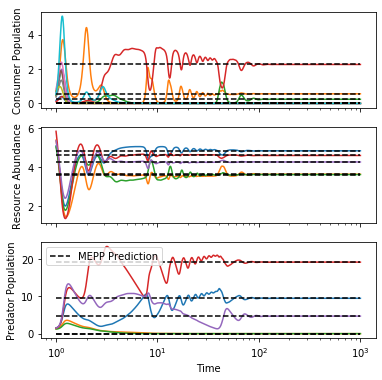

In [92]:
#Parameters
S = 10
MR = 5
MP = 5
params = {'c':np.random.rand(S,MR),
          'p':np.random.rand(S,MP),
          'm':np.random.rand(S)+1,
          'u':np.random.rand(MP)+1,
          'w':np.random.rand(MR)+1,
          'r':np.random.rand(MR)+1,
          'R0':np.random.rand(MR)+5}
N_init = np.random.rand(S)
R_init = params['R0']
P_init = np.random.rand(MP)+1
tmin = 1
tmax= 1000

#ODE
def dydt(t,y):
    N = y[:S]
    R = y[S:S+MR]
    P = y[S+MR:]
    dNdt = N*((params['c']*params['w']).dot(R)-params['p'].dot(P)-params['m'])
    dRdt = params['r']*R*(params['R0']-R) - (params['c'].T.dot(N))*R
    dPdt = (params['p'].T.dot(N))*P-params['u']*P
    return np.hstack((dNdt,dRdt,dPdt))
out_ODE = solve_ivp(dydt,(tmin,tmax),np.hstack((N_init,R_init,P_init)),t_eval=np.logspace(np.log10(tmin),np.log10(tmax),1000))
t = out_ODE.t
N = out_ODE.y[:S,:].T
R = out_ODE.y[S:S+MR,:].T
P = out_ODE.y[S+MR:,:].T

#Constrained optimization
noninvadable = LinearConstraint(np.hstack((params['c']*params['w'],-params['p'])),-np.inf*np.ones(S),params['m'])
resource_feasible = Bounds(0,np.inf)
def d(RP):
    R = RP[:MR]
    P = RP[MR:]                   
    return 0.5*((R-params['R0'])**2*params['w']*params['r']).sum() + params['u'].dot(P)
out_opt = minimize(d, np.hstack((R_init,P_init)), method='trust-constr', constraints=noninvadable, bounds=resource_feasible)
Rstar = out_opt.x[:MR]
Pstar = out_opt.x[MR:]
Nstar = out_opt.v[0]

fig,ax=plt.subplots(3,sharex=True,figsize=(6,6))
#Plot ODE results
ax[0].semilogx(t,N)
ax[1].semilogx(t,R)
ax[2].semilogx(t,P)
#Plot optimization results
ax[0].plot([t[0],t[-1]],[Nstar,Nstar],'k--')
ax[1].plot([t[0],t[-1]],[Rstar,Rstar],'k--')
ax[2].plot([t[0],t[-1]],[Pstar,Pstar],'k--')
#Make legend
ax[2].plot([],[],'k--',label='MEPP Prediction')
ax[2].legend()
#Make labels
ax[2].set_xlabel('Time')
ax[0].set_ylabel('Consumer Population')
ax[1].set_ylabel('Resource Abundance')
ax[2].set_ylabel('Predator Population')
plt.show()

# Chemostat

\begin{align}
\frac{dN_i}{dt} &= N_i \left[ \sum_{\alpha} w_\alpha c_{i\alpha} R_\alpha - \tau^{-1}\right]\\
\frac{dR_\alpha}{dt} &= \tau^{-1} (R_\alpha^0 - R_\alpha) - \sum_i N_i c_{i\alpha} R_\alpha.
\end{align}

\begin{align}
d(\mathbf{R}^0,\mathbf{R}) &= \tau^{-1} \sum_\alpha w_\alpha\left[R_\alpha^0 \ln \frac{R_\alpha^0}{R_\alpha} - (R_\alpha^0 - R_\alpha)\right] \\
\sum_{\alpha} w_\alpha c_{i\alpha} R_\alpha &\leq \tau^{-1}
\end{align}

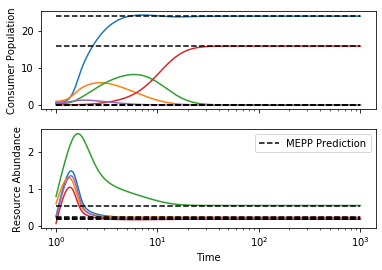

In [96]:
#Parameters
S = 5
M = 5
params = {'c':np.random.rand(S,M),
          'w':np.random.rand(M)+1,
          'tau':1,
          'R0':np.random.rand(M)+5}
N_init = np.random.rand(S)
R_init = np.random.rand(M)
tmin = 1
tmax= 1000

#ODE
def dydt(t,y):
    N = y[:S]
    R = y[S:]
    dNdt = N*((params['c']*params['w']).dot(R)-1/params['tau'])
    dRdt = (params['R0']-R)/params['tau'] - (params['c'].T.dot(N))*R
    return np.hstack((dNdt,dRdt))
out_ODE = solve_ivp(dydt,(tmin,tmax),np.hstack((N_init,R_init)),t_eval=np.logspace(np.log10(tmin),np.log10(tmax),1000))
t = out_ODE.t
N = out_ODE.y[:S,:].T
R = out_ODE.y[S:,:].T

#Constrained optimization
noninvadable = LinearConstraint(params['c']*params['w'],-np.inf*np.ones(S),np.ones(S)/params['tau'])
resource_feasible = Bounds(0,np.inf)
def d(R):
    return params['w'].dot(kl_div(params['R0'],R))/params['tau']
def jac(R):
    return params['w']*(R-params['R0'])/R
def hess(R):
    return np.diag(params['w']*params['R0']/R**2)
out_opt = minimize(d, R_init, method='trust-constr', constraints=noninvadable, bounds=resource_feasible, jac=jac, hess=hess)
Rstar = out_opt.x
Nstar = out_opt.v[0]

fig,ax=plt.subplots(2,sharex=True)
#Plot ODE results
ax[0].semilogx(t,N)
ax[1].semilogx(t,R)
#Plot optimization results
ax[0].plot([t[0],t[-1]],[Nstar,Nstar],'k--')
ax[1].plot([t[0],t[-1]],[Rstar,Rstar],'k--')
#Make legend
ax[1].plot([],[],'k--',label='MEPP Prediction')
ax[1].legend()
#Make labels
ax[1].set_xlabel('Time')
ax[0].set_ylabel('Consumer Population')
ax[1].set_ylabel('Resource Abundance')
plt.show()

# Saturating

\begin{align}
\frac{dN_i}{dt} &= N_i \left[\frac{e_i K_i \sum_\alpha w_\alpha c_{i\alpha}R_\alpha}{K_i + \sum_\alpha w_\alpha c_{i\alpha}R_\alpha} - m_i - \tau^{-1} \right]\\
\frac{dR_\alpha}{dt} &= \tau^{-1} (R_\alpha^0 - R_\alpha) - \sum_i N_i\frac{K_i c_{i\alpha}R_\alpha}{K_i+\sum_\beta w_\beta c_{i\beta}R_\beta}.
\end{align}

\begin{align}
d(\mathbf{R}^0,\mathbf{R}) &= \tau^{-1} \sum_\alpha w_\alpha\left[R_\alpha^0 \ln \frac{R_\alpha^0}{R_\alpha} - (R_\alpha^0 - R_\alpha)\right] \\
\frac{K_i \sum_\alpha w_\alpha c_{i\alpha}R_\alpha}{K_i + \sum_\alpha w_\alpha c_{i\alpha}R_\alpha}-m_i &\leq \tau^{-1}
\end{align}

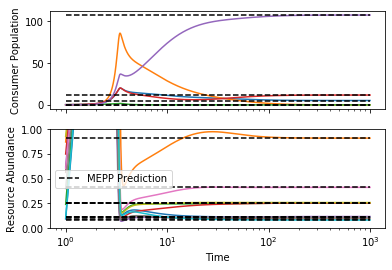

In [101]:
#Parameters
S = 5
M = 10
params = {'c':np.random.rand(S,M),
          'e':np.random.rand(S)+3,
          'm':np.random.rand(S)+1,
          'w':np.random.rand(M)+1,
          'K':np.random.rand(S)+1,
          'tau':1,
          'R0':np.random.rand(M)+5}
N_init = np.random.rand(S)
R_init = np.random.rand(M)
tmin = 1
tmax= 1000

#ODE
def g(R):
    return params['e']*params['K']*(params['c']*params['w']).dot(R)/(params['K']+(params['c']*params['w']).dot(R)) - params['m']
def g_jac(R):
    return ((params['c']*params['w']).T*params['K']**2*params['e']/(params['K']+(params['c']*params['w']).dot(R))**2).T
def g_hess(R,v):
    return np.einsum('i,ij,ik',-v*2*params['K']**2*params['e']/(params['K']+(params['c']*params['w']).dot(R))**3,params['c']*params['w'],params['c']*params['w'])
def dydt(t,y):
    N = y[:S]
    R = y[S:]
    dNdt = N*(g(R)-1/params['tau'])
    dRdt = (params['R0']-R)/params['tau'] - (params['c']*R).T.dot(params['K']*N/(params['K']+(params['c']*params['w']).dot(R)))
    return np.hstack((dNdt,dRdt))
out_ODE = solve_ivp(dydt,(tmin,tmax),np.hstack((N_init,R_init)),t_eval=np.logspace(np.log10(tmin),np.log10(tmax),1000))
t = out_ODE.t
N = out_ODE.y[:S,:].T
R = out_ODE.y[S:,:].T

#Constrained optimization
noninvadable = NonlinearConstraint(g,-np.inf,1/params['tau'],jac=g_jac,hess=g_hess)
resource_feasible = Bounds(0,np.inf)
def d(R):
    return params['w'].dot(kl_div(params['R0'],R))/params['tau']
def jac(R):
    return params['w']*(R-params['R0'])/R
def hess(R):
    return np.diag(params['w']*params['R0']/R**2)
out_opt = minimize(d, R_init, method='trust-constr', constraints=noninvadable, bounds=resource_feasible, jac=jac, hess=hess)
Rstar = out_opt.x
Nstar = out_opt.v[0]*params['K']*params['e']/(params['K']+(params['c']*params['w']).dot(Rstar))

fig,ax=plt.subplots(2,sharex=True)
#Plot ODE results
ax[0].semilogx(t,N)
ax[1].semilogx(t,R)
#Plot optimization results
ax[0].plot([t[0],t[-1]],[Nstar,Nstar],'k--')
ax[1].plot([t[0],t[-1]],[Rstar,Rstar],'k--')
#Make legend
ax[1].plot([],[],'k--',label='MEPP Prediction')
ax[1].legend()
#Make labels
ax[1].set_xlabel('Time')
ax[0].set_ylabel('Consumer Population')
ax[1].set_ylabel('Resource Abundance')
ax[1].set_ylim((0,1))
plt.show()

# Liebig's Law

## Interactively essential resources

\begin{align}
\frac{dN_i}{dt} &= N_i \left[\left(\sum_\alpha \frac{1}{c_{i\alpha}^n R_\alpha^n}\right)^{-1/n} - \tau^{-1}\right]\\
\frac{dR_\alpha}{dt} &= \tau^{-1} (R_\alpha^0 - R_\alpha) - \sum_{i,\beta} N_i b_{\alpha\beta}\frac{1}{c_{i\beta}^nR_\beta^n} \left(\sum_\gamma \frac{1}{c_{i\gamma}^n R_\gamma^n}\right)^{-1/n-1}.
\end{align}

\begin{align}
d(\mathbf{R}^0,\mathbf{R}) &= \tau^{-1} \sum_\alpha w_\alpha \left[R_\alpha^0 \ln \frac{R_\alpha^0}{R_\alpha} - (R_\alpha^0 - R_\alpha)\right] \\
\tilde{R}_\alpha^0 &= R_\alpha^0 + \sum_{\beta\neq \alpha} \frac{(b^{-1})_{\alpha\beta}}{(b^{-1})_{\alpha\alpha}}(R_\beta^0-R_\beta^*)\\
\tilde{w}_\alpha &= (b^{-1})_{\alpha\alpha}\\
\left(\sum_\alpha \frac{1}{c_{i\alpha}^n R_\alpha^n}\right)^{-1/n}&\leq \tau^{-1}
\end{align}

Justification:
\begin{align}
q_{i\alpha} = - \sum_\beta b_{\alpha\beta}R_\beta\partial_\beta g
\end{align}

\begin{align}
-\partial_\alpha d = \sum_\beta (b^{-1})_{\alpha\beta}\frac{R_\beta^0 - R_\beta}{R_\alpha} = (b^{-1})_{\alpha\alpha}\frac{\tilde{R}_\alpha^0 - R_\alpha}{R_\alpha}
\end{align}

\begin{align}
\tilde{R}_\alpha^0 &= R_\alpha^0 + \sum_{\beta\neq \alpha} \frac{(b^{-1})_{\alpha\beta}}{(b^{-1})_{\alpha\alpha}}(R_\beta^0-R_\beta^*)
\end{align}

\begin{align}
-\partial_\beta \partial_\alpha d = -(b^{-1})_{\alpha\beta}\frac{R_\beta^0}{R_\alpha}
\end{align}

\begin{align}
-\partial_\alpha \partial_\beta d = -(b^{-1})_{\beta\alpha}\frac{R_\alpha^0}{R_\beta}
\end{align}

## Essential resources

\begin{align}
\frac{dN_i}{dt} &= N_i \left[{\rm min}\left(\left\{c_{i\alpha} R_\alpha\right\}\right) - \tau^{-1}\right]\\
\frac{dR_\alpha}{dt} &= \tau^{-1} (R_\alpha^0 - R_\alpha) - \sum_{i} N_i b_{\alpha\beta_i} c_{i\beta_i}R_{\beta_i}
\end{align}

\begin{align}
d(\mathbf{R}^0,\mathbf{R}) &= \tau^{-1} \sum_\alpha w_\alpha \left[R_\alpha^0 \ln \frac{R_\alpha^0}{R_\alpha} - (R_\alpha^0 - R_\alpha)\right] \\
\tilde{R}_\alpha^0 &= R_\alpha^0 + \sum_{\beta\neq \alpha} \frac{(b^{-1})_{\alpha\beta}}{(b^{-1})_{\alpha\alpha}}(R_\beta^0-R_\beta^*)\\
\tilde{w}_\alpha &= (b^{-1})_{\alpha\alpha}\\
{\rm min}\left(\left\{c_{i\alpha} R_\alpha\right\}\right) &\leq \tau^{-1}
\end{align}

### Independent optimization and integration

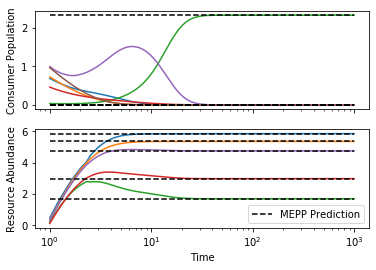

In [102]:
#Parameters
S = 6
M = 5
params = {'c':np.random.rand(S,M),
          'm':np.random.rand(S)+1,
          'b':np.random.rand(M,M)+np.eye(M),
          'tau':1,
          'R0':np.random.rand(M)+5}
params['binv'] = np.linalg.inv(params['b'])
params['w'] = np.diag(params['binv'])
N_init = np.random.rand(S)
R_init = np.random.rand(M)
tmin = 1
tmax= 1000

#ODE
def g(R):
    return np.min(params['c']*R,axis=1)
def b(R):
    return np.asarray([params['b'][:,np.argmin(params['c'][k,:]*R)] for k in range(S)])
def g_jac(R):
    jac = np.zeros((S,M))
    for k in range(S):
        jmin = np.argmin(params['c'][k,:]*R)
        jac[k,jmin] = params['c'][k,jmin]
    return jac
def g_hess(R,v):
    return np.zeros((M,M))
def dydt(t,y):
    N = y[:S]
    R = y[S:]
    dNdt = N*(g(R)-1/params['tau'])
    dRdt = (params['R0']-R)/params['tau'] - b(R).T.dot(g(R)*N)
    return np.hstack((dNdt,dRdt))
out_ODE = solve_ivp(dydt,(tmin,tmax),np.hstack((N_init,R_init)),t_eval=np.logspace(np.log10(tmin),np.log10(tmax),1000))
t = out_ODE.t
N = out_ODE.y[:S,:].T
R = out_ODE.y[S:,:].T

#Constrained optimization
noninvadable = NonlinearConstraint(g,-np.inf,1/params['tau'],jac=g_jac,hess=g_hess)
resource_feasible = Bounds(0,np.inf)

def d(R,Rstar):
    R0t = params['R0']+(params['binv']-np.diag(params['w'])).dot(params['R0']-Rstar)/params['w']
    return params['w'].dot(kl_div(R0t,R))
def jac(R,Rstar):
    R0t = params['R0']+(params['binv']-np.diag(params['w'])).dot(params['R0']-Rstar)/params['w']
    return params['w']*(R-R0t)/R
def hess(R,Rstar):
    R0t = params['R0']+(params['binv']-np.diag(params['w'])).dot(params['R0']-Rstar)/params['w']
    return np.diag(params['w']*R0t/R**2)
Rstar = params['R0']
Rstar_old = np.zeros(M)
eps = 1e-3
max_iter = 100
k = 0
while np.linalg.norm(Rstar-Rstar_old) > eps and k < max_iter:
    out_opt = minimize(lambda R: d(R,Rstar), Rstar, method='trust-constr', constraints=noninvadable, bounds=resource_feasible, jac=lambda R: jac(R,Rstar), hess=lambda R: hess(R,Rstar))
    Rstar_old = Rstar
    Rstar = out_opt.x
    k+=1
Nstar = out_opt.v[0]

fig,ax=plt.subplots(2,sharex=True)
#Plot ODE results
ax[0].semilogx(t,N)
ax[1].semilogx(t,R)
#Plot optimization results
ax[0].plot([t[0],t[-1]],[Nstar,Nstar],'k--')
ax[1].plot([t[0],t[-1]],[Rstar,Rstar],'k--')
#Make legend
ax[1].plot([],[],'k--',label='MEPP Prediction')
ax[1].legend()
#Make labels
ax[1].set_xlabel('Time')
ax[0].set_ylabel('Consumer Population')
ax[1].set_ylabel('Resource Abundance')
plt.show()

### Start integration in same basin of attraction as optimization

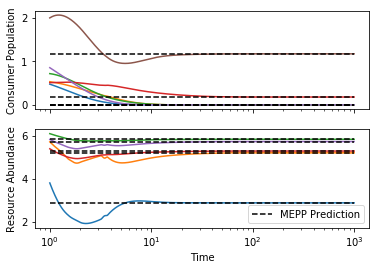

In [70]:
#Parameters
S = 6
M = 5
params = {'c':np.random.rand(S,M),
          'm':np.random.rand(S)+1,
          'b':np.random.rand(M,M)+np.eye(M),
          'tau':1,
          'R0':np.random.rand(M)+5}
params['binv'] = np.linalg.inv(params['b'])
params['w'] = np.diag(params['binv'])
tmin = 1
tmax= 1000

#Constrained optimization
noninvadable = NonlinearConstraint(g,-np.inf,1/params['tau'],jac=g_jac,hess=g_hess)
resource_feasible = Bounds(0,np.inf)
def d(R,Rstar):
    R0t = params['R0']+(params['binv']-np.diag(params['w'])).dot(params['R0']-Rstar)/params['w']
    return params['w'].dot(kl_div(R0t,R))
def jac(R,Rstar):
    R0t = params['R0']+(params['binv']-np.diag(params['w'])).dot(params['R0']-Rstar)/params['w']
    return params['w']*(R-R0t)/R
def hess(R,Rstar):
    R0t = params['R0']+(params['binv']-np.diag(params['w'])).dot(params['R0']-Rstar)/params['w']
    return np.diag(params['w']*R0t/R**2)
Rstar = params['R0']
Rstar_old = np.zeros(M)
eps = 1e-8
max_iter = 100
k = 0
while np.linalg.norm(Rstar-Rstar_old) > eps and k < max_iter:
    out_opt = minimize(lambda R: d(R,Rstar), Rstar, method='trust-constr', constraints=noninvadable, bounds=resource_feasible, jac=lambda R: jac(R,Rstar), hess=lambda R: hess(R,Rstar))
    Rstar_old = Rstar
    Rstar = out_opt.x
    k+=1
Nstar = out_opt.v[0]

#ODE
def g(R):
    return np.min(params['c']*R,axis=1)
def b(R):
    return np.asarray([params['b'][:,np.argmin(params['c'][k,:]*R)] for k in range(S)])
def g_jac(R):
    jac = np.zeros((S,M))
    for k in range(S):
        jmin = np.argmin(params['c'][k,:]*R)
        jac[k,jmin] = params['c'][k,jmin]
    return jac
def g_hess(R,v):
    return np.zeros((M,M))
def dydt(t,y):
    N = y[:S]
    R = y[S:]
    dNdt = N*(g(R)-1/params['tau'])
    dRdt = (params['R0']-R)/params['tau'] - b(R).T.dot(g(R)*N)
    return np.hstack((dNdt,dRdt))
out_ODE = solve_ivp(dydt,(tmin,tmax),np.hstack((Nstar+np.random.rand(S),Rstar+np.random.rand(M))),t_eval=np.logspace(np.log10(tmin),np.log10(tmax),1000))
t = out_ODE.t
N = out_ODE.y[:S,:].T
R = out_ODE.y[S:,:].T

fig,ax=plt.subplots(2,sharex=True)
#Plot ODE results
ax[0].semilogx(t,N)
ax[1].semilogx(t,R)
#Plot optimization results
ax[0].plot([t[0],t[-1]],[Nstar,Nstar],'k--')
ax[1].plot([t[0],t[-1]],[Rstar,Rstar],'k--')
#Make legend
ax[1].plot([],[],'k--',label='MEPP Prediction')
ax[1].legend()
#Make labels
ax[1].set_xlabel('Time')
ax[0].set_ylabel('Consumer Population')
ax[1].set_ylabel('Resource Abundance')
plt.show()

# Microbial Consumer Resource Model

\begin{align}
\frac{dN_i}{dt} &= N_i \left[\sum_\alpha (1-l_\alpha) w_\alpha c_{i\alpha} R_\alpha - m_i\right]\\
\frac{dR_\alpha}{dt} &= \tau^{-1} (R_\alpha^0 - R_\alpha) - \sum_{i,\beta} N_i\frac{\delta_{\alpha\beta} - D_{\alpha\beta}l_\beta}{w_\alpha(1-l_\beta)}(1-l_\beta)w_\beta c_{i\beta}R_\beta = \tau^{-1} (R_\alpha^0 - R_\alpha) - \sum_{i,\beta} N_i Q_{\alpha\beta}\partial_\beta g_i
\end{align}

\begin{align}
d(\mathbf{R}^0,\mathbf{R}) &= \tau^{-1} \sum_\alpha w_\alpha \left[R_\alpha^0 \ln \frac{R_\alpha^0}{R_\alpha} - (R_\alpha^0 - R_\alpha)\right] \\
\tilde{R}_\alpha^0 &= R_\alpha^0 + \sum_{\beta\neq \alpha} \frac{(Q^{-1})_{\alpha\beta}}{(Q^{-1})_{\alpha\alpha}}(R_\beta^0-R_\beta^*)\\
\tilde{w} &= (Q^{-1})_{\alpha\alpha}\\
\sum_\alpha w_\alpha c_{i\alpha} R_\alpha &\leq m_i
\end{align}

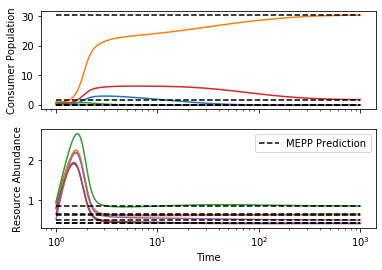

In [86]:
#Parameters
S = 5
M = 6
params = {'c':np.random.rand(S,M),
          'm':np.random.rand(S)+1,
          'w':np.random.rand(M)+1,
          'l':np.random.rand(M),
          'tau':1,
          'D':np.random.dirichlet(np.ones(M)*10,size=M).T,
          'R0':np.random.rand(M)+5}
params['Q'] = (((np.eye(M)-params['D']*params['l'])/(1-params['l'])).T/params['w']).T
params['Qinv'] = np.linalg.inv(params['Q'])
params['wt'] = np.diag(params['Qinv'])
N_init = np.random.rand(S)
R_init = np.random.rand(M)
tmin = 1
tmax= 1000

#ODE
def dydt(t,y):
    N = y[:S]
    R = y[S:]
    dNdt = N*((params['c']*params['w']*(1-params['l'])).dot(R)-params['m'])
    dRdt = (params['R0']-R)/params['tau'] - (params['c'].T.dot(N))*R + (params['D']*params['l']).dot((params['c']*params['w']).T.dot(N)*R)/params['w']
    return np.hstack((dNdt,dRdt))
out_ODE = solve_ivp(dydt,(tmin,tmax),np.hstack((N_init,R_init)),t_eval=np.logspace(np.log10(tmin),np.log10(tmax),1000))
t = out_ODE.t
N = out_ODE.y[:S,:].T
R = out_ODE.y[S:,:].T

#Constrained optimization
noninvadable = LinearConstraint(params['c']*params['w']*(1-params['l']),-np.inf*np.ones(S),params['m'])
resource_feasible = Bounds(0,np.inf)
def d(R,Rstar):
    R0t = params['R0']+(params['Qinv']-np.diag(params['wt'])).dot(params['R0']-Rstar)/params['wt']
    return params['wt'].dot(kl_div(R0t,R))
def jac(R,Rstar):
    R0t = params['R0']+(params['Qinv']-np.diag(params['wt'])).dot(params['R0']-Rstar)/params['wt']
    return params['wt']*(R-R0t)/R
def hess(R,Rstar):
    R0t = params['R0']+(params['Qinv']-np.diag(params['wt'])).dot(params['R0']-Rstar)/params['wt']
    return np.diag(params['wt']*R0t/R**2)
Rstar = params['R0']
Rstar_old = np.zeros(M)
eps = 1e-3
max_iter = 100
k = 0
while np.linalg.norm(Rstar-Rstar_old) > eps and k < max_iter:
    out_opt = minimize(lambda R: d(R,Rstar), Rstar, method='trust-constr', constraints=noninvadable, bounds=resource_feasible, jac=lambda R: jac(R,Rstar), hess=lambda R: hess(R,Rstar))
    Rstar_old = Rstar
    Rstar = out_opt.x
    k+=1
Nstar = out_opt.v[0]

fig,ax=plt.subplots(2,sharex=True)
#Plot ODE results
ax[0].semilogx(t,N)
ax[1].semilogx(t,R)
#Plot optimization results
ax[0].plot([t[0],t[-1]],[Nstar,Nstar],'k--')
ax[1].plot([t[0],t[-1]],[Rstar,Rstar],'k--')
#Make legend
ax[1].plot([],[],'k--',label='MEPP Prediction')
ax[1].legend()
#Make labels
ax[1].set_xlabel('Time')
ax[0].set_ylabel('Consumer Population')
ax[1].set_ylabel('Resource Abundance')
plt.show()

## Is there a minimized function?

The EM algorithm guarantees that the likelihood is maximized. In this special application of EM, I think we can obtain a closed-form expression for the likelihood.

To find out what the likelihood is, in the analogy, let us start by defining the Lagrangian

\begin{align}
\mathcal{L}(\mathbf{R}|z) = d(z,\mathbf{R}) - \sum_i N_i g_i(\mathbf{R}).
\end{align}

(Make sure not to confuse $g_i$ with the $g$ we will have later on!!) It is this function that must be minimized over $\mathbf{R}$ to find the steady state of the community, with the latent variable $z$ set equal to $\tilde{\mathbf{R}}^0$ as defined above. 

In the notation of Dempster1977, the function employed in the expectation-maximization procedure is

\begin{align}
Q(\mathbf{R}'|\mathbf{R}) = E(\log f(z|\mathbf{R}')|y,\mathbf{R}) = \log f(z(\mathbf{R})|\mathbf{R}') = - \mathcal{L}(\mathbf{R}',z(\mathbf{R}))
\end{align}

where $y$ is a binary variable indicating whether the system is in an equilibrium state. When it equals 1, we set $z = z(\mathbf{R})$. Now the EM algorithm just optimizes this over $\mathbf{R}'$, updates $\mathbf{R}$ with this new optimal value, and repeates the process. This is exactly what our code does above.


The trouble is that $f(z|\mathbf{R})$ in this scheme is not a normalized probability distribution. But I think it is sufficient to define a normalized distribution

\begin{align}
k(z|\mathbf{R}) = \frac{f(z|\mathbf{R})}{g(\mathbf{R})}
\end{align}

where

\begin{align}
g(\mathbf{R}) \equiv \int dz\,f(z|\mathbf{R}).
\end{align}

Then we can define

\begin{align}
L(\mathbf{R}') = \log g(\mathbf{R}') = Q(\mathbf{R}'|\mathbf{R}) - H(\mathbf{R}'|\mathbf{R})
\end{align}

where

\begin{align}
H(\mathbf{R}'|\mathbf{R}) = E(\log k(z|\mathbf{R}')|y,\mathbf{R}) = \log k(z(\mathbf{R})|\mathbf{R}').
\end{align}

If we can show that

\begin{align}
H(\mathbf{R}'|\mathbf{R}) \leq H(\mathbf{R}|\mathbf{R})
\end{align}

for all $\mathbf{R}'$, then it follows (see Dempster1977, 3.10) that $L(\mathbf{R}')$ always increases under EM. If this doesn't work, we can try defining a different $g(\mathbf{R})$. If we can find some $g$ such that this last condition holds, then that function will be maximized.

It turns out that this is impossible, because you end up needing a log $g$ whose derivative is equal to a function with nonzero curl.

To see why, let us define $l(\mathbf{R})$ (without loss of generality) such that

\begin{align}
\log g(\mathbf{R}) = - \mathcal{L}(\mathbf{R}|z(\mathbf{R})) - l(\mathbf{R}).
\end{align}

Now we have 

\begin{align}
\log k(z|\mathbf{R}) &= -\mathcal{L}(\mathbf{R}|z) + \mathcal{L}(\mathbf{R}|z(\mathbf{R})) + l(\mathbf{R})\\
&= -[d(z,\mathbf{R})-d(z(\mathbf{R}),\mathbf{R})] + l(\mathbf{R})
\end{align}

Thus we find:

\begin{align}
H(\mathbf{R}'|\mathbf{R}) = -[d(z(\mathbf{R}),\mathbf{R}')-d(z(\mathbf{R}'),\mathbf{R}')] + l(\mathbf{R}').
\end{align}

Now for this to be maximized (with respect to variations in $\mathbf{R}'$) at $\mathbf{R}' = \mathbf{R}$, we need:

\begin{align}
0 = \frac{\partial H(\mathbf{R}'|\mathbf{R})}{\partial R_\alpha'} = \frac{\partial d(z(\mathbf{R}'),\mathbf{R}')}{\partial z} \frac{\partial z(\mathbf{R}')}{\partial R_\alpha'} + \frac{\partial l(\mathbf{R}')}{\partial R_\alpha'}
\end{align}

because the derivatives with respect to the second arguments of the $d$'s cancel out. The trouble with this is that the right-hand-side makes no reference to $\mathbf{R}$. So either the function is constant, which would send us to a trivial case, or it can only be maximized at a single value of $\mathbf{R}$. We are free to pick $l(\mathbf{R}')$ in such a way that the maximum happens at the true steady-state value $\mathbf{R} = \mathbf{R}^*$, but then we are back where we started, because the whole point was to find an objective function that is known a priori.

The way this differs from standard EM is that our "measurements" constrain the latent variables in a way that depends on the choice of parameters. Whereas in the Dempster setup, the mapping of allowed latent values to measurements is parameter-independent, and the parameters just alter the probability distribution over the fixed set of possibilities.

### Better way

The basic setup of our problem is as follows. We know $Q(\phi'|\phi)$ and want to find $g(\phi)$. I am suppressing the observed data $y$, because we only care about a single "observation" right now. The main consequence of restricting to the space compatible with the observation is that the restricted $f(x|\phi)$ need not be normalized. We also know that the probability of the latent variable $z$ is tightly localized around some $z(\phi)$. 

We thus have:
\begin{align}
Q(\phi'|\phi) = \int_y f(x|\phi) \log f(x|\phi') \, dx= f(z(\phi)|\phi) \log f(z(\phi)|\phi')).
\end{align}

And the maximized function is
\begin{align}
g(\phi) &= \int_y f(x|\phi)\, dx = f(z(\phi)|\phi).
\end{align}

So the problem is to put the first expression into this form and extract $f$.

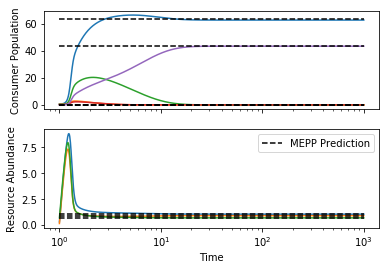

In [83]:
#Parameters
S = 5
M = 3
params = {'c':np.random.rand(S,M),
          'm':np.random.rand(S)+2,
          'w':np.random.rand(M)+1,
          'l':np.random.rand(M),
          'tau':1,
          'D':np.random.dirichlet(np.ones(M)*10,size=M).T,
          'R0':np.random.rand(M)+50}
params['Q'] = (((np.eye(M)-params['D']*params['l'])/(1-params['l'])).T/params['w']).T
params['wt'] = np.diag(np.linalg.inv(params['Q']))
params['Qinv'] = np.linalg.inv(params['Q'])-np.diag(params['wt'])
N_init = np.random.rand(S)
R_init = np.random.rand(M)
tmin = 1
tmax= 1000
a = -71.0737
b = 71.9444
c = 0.00713408

#ODE
def dydt(t,y):
    N = y[:S]
    R = y[S:]
    dNdt = N*((params['c']*params['w']*(1-params['l'])).dot(R)-params['m'])
    dRdt = (params['R0']-R)/params['tau'] - (params['c'].T.dot(N))*R + (params['D']*params['l']).dot((params['c']*params['w']).T.dot(N)*R)/params['w']
    return np.hstack((dNdt,dRdt))
out_ODE = solve_ivp(dydt,(tmin,tmax),np.hstack((N_init,R_init)),t_eval=np.logspace(np.log10(tmin),np.log10(tmax),1000))
t = out_ODE.t
N = out_ODE.y[:S,:].T
R = out_ODE.y[S:,:].T

#Constrained optimization
noninvadable = LinearConstraint(params['c']*params['w']*(1-params['l']),-np.inf*np.ones(S),params['m'])
resource_feasible = Bounds(0.2,np.inf)
def d(R):
    R0t = np.abs(params['R0']+params['Qinv'].dot(params['R0']-R)/params['wt'])
    return params['wt'].dot(kl_div(R0t,R))+((a+b*(params['wt']*R)**c)/params['wt']).sum()
def jac(R):
    R0t = params['R0']+params['Qinv'].dot(params['R0']-R)/params['wt']
    return params['wt']*(R-R0t)/R - params['Qinv'].T.dot(np.log(R0t/R))+b*c*(params['wt']*R)**(c-1)
def hess(R):
    R0t = params['R0']+params['Qinv'].dot(params['R0']-R)/params['wt']
    return np.diag(params['wt']*R0t/R**2+b*c*(c-1)*params['wt']*(params['wt']*R)**(c-2))+(params['Qinv'].T/R).T+(params['Qinv'].T/R)+(params['Qinv'].T/(params['wt']*R0t)).dot(params['Qinv'])

out_opt = minimize(d, R_init*0.01, method='trust-constr', constraints=noninvadable, bounds=resource_feasible, jac=jac, hess=hess)
Rstar = out_opt.x
Nstar = out_opt.v[0]

fig,ax=plt.subplots(2,sharex=True)
#Plot ODE results
ax[0].semilogx(t,N)
ax[1].semilogx(t,R)
#Plot optimization results
ax[0].plot([t[0],t[-1]],[Nstar,Nstar],'k--')
ax[1].plot([t[0],t[-1]],[Rstar,Rstar],'k--')
#Make legend
ax[1].plot([],[],'k--',label='MEPP Prediction')
ax[1].legend()
#Make labels
ax[1].set_xlabel('Time')
ax[0].set_ylabel('Consumer Population')
ax[1].set_ylabel('Resource Abundance')
plt.show()

In [6]:
out_opt

 barrier_parameter: 3.200000000000001e-05
 barrier_tolerance: 3.200000000000001e-05
          cg_niter: 73
      cg_stop_cond: 1
            constr: [array([1.87651747, 1.3806662 , 1.27012785, 1.45321006, 1.03836767]), array([0.62536756, 0.30380615, 0.26092302, 5.92480823, 0.4982634 ,
       0.75746475])]
       constr_nfev: [0, 0]
       constr_nhev: [0, 0]
       constr_njev: [0, 0]
    constr_penalty: 1.0
  constr_violation: 0.0
    execution_time: 0.03883099555969238
               fun: 75.87981466942705
              grad: array([ -7.98202257, -34.51105815, -31.05148642,  -2.7871908 ,
       -10.44798377, -14.90558793])
               jac: [array([[0.35492667, 0.22524167, 0.75664459, 0.13816514, 0.37403684,
        0.50659946],
       [0.20133063, 0.49254596, 0.49944017, 0.06523724, 0.42684943,
        0.49587133],
       [0.17348628, 1.07580489, 0.91946149, 0.06494003, 0.08633617,
        0.22062407],
       [0.10698193, 0.12522773, 0.06507192, 0.13621063, 0.20555092,
        0.5

In [24]:
F = np.asarray([-0.0180059, 0.0449668, 0.156091, 0.306361, 0.491116, 0.707465, 
0.95343, 1.22757, 1.5288, 1.85627, 2.20928, 2.58729, 2.98982, 
3.41648, 3.86695, 4.34093, 4.83819, 5.3585, 5.90167, 6.46754, 
7.05595, 7.66678, 8.2999, 8.9552, 9.63259, 10.332, 11.0533, 11.7964, 
12.5613, 13.3479, 14.1562, 14.986, 15.8374, 16.7103, 17.6046, 
18.5203, 19.4574, 20.4159, 21.3956, 22.3966, 23.4188, 24.4622, 
25.5268, 26.6125, 27.7194, 28.8473, 29.9964, 31.1664, 32.3575, 
33.5696, 34.8027, 36.0568, 37.3318, 38.6277, 39.9446, 41.2823, 
42.641, 44.0205, 45.4209, 46.8421, 48.2841, 49.747, 51.2306, 52.735, 
54.2603, 55.8062, 57.373, 58.9604, 60.5686, 62.1975, 63.8472, 
65.5175, 67.2085, 68.9202, 70.6526, 72.4056, 74.1793, 75.9737, 
77.7887, 79.6243, 81.4805, 83.3574, 85.2548, 87.1729, 89.1115, 
91.0708, 93.0506, 95.051, 97.0719, 99.1135, 101.176, 103.258, 
105.361, 107.485, 109.629, 111.794, 113.979, 116.185, 118.411, 
120.658, 122.925, 125.213, 127.522, 129.85, 132.2, 134.569, 136.96, 
139.37, 141.801, 144.253, 146.725, 149.217, 151.73, 154.264, 156.818, 
159.392, 161.986, 164.602, 167.237, 169.893, 172.569, 175.266, 
177.983, 180.721, 183.479, 186.257, 189.056, 191.875, 194.715, 
197.575, 200.455, 203.356, 206.277, 209.219, 212.18, 215.163, 
218.165, 221.188, 224.232, 227.295, 230.379, 233.484, 236.608, 
239.753, 242.919, 246.105, 249.311, 252.537, 255.784, 259.051, 
262.339, 265.647, 268.975, 272.323, 275.692, 279.081, 282.49, 285.92, 
289.37, 292.841, 296.331, 299.842, 303.374, 306.925, 310.497, 
314.089, 317.702, 321.335, 324.988, 328.661, 332.355, 336.069, 
339.803, 343.558, 347.333, 351.128, 354.943, 358.779, 362.635, 
366.511, 370.408, 374.325, 378.262, 382.219, 386.197, 390.195, 
394.213, 398.251, 402.31, 406.389, 410.488, 414.608, 418.748,
422.908, 427.088, 431.289, 435.509, 439.75, 444.012, 448.293, 
452.595, 456.917, 461.259, 465.622, 470.005, 474.408, 478.831, 
483.275, 487.738, 492.222, 496.727, 501.251, 505.796, 510.361, 
514.946, 519.551, 524.177, 528.823, 533.489, 538.175, 542.882, 
547.609, 552.356, 557.123, 561.911, 566.718, 571.546, 576.394, 
581.263, 586.151, 591.06, 595.989, 600.938, 605.908, 610.897, 
615.907, 620.937, 625.987, 631.058, 636.149, 641.259, 646.391, 
651.542, 656.713, 661.905, 667.117, 672.349, 677.602, 682.874, 
688.167, 693.48, 698.813, 704.166, 709.54, 714.934, 720.347, 725.782, 
731.236, 736.71, 742.205, 747.72, 753.255, 758.81, 764.386, 769.982, 
775.597, 781.233, 786.89, 792.566, 798.263, 803.979, 809.716, 
815.474, 821.251, 827.048, 832.866, 838.704, 844.562, 850.44, 
856.339, 862.257, 868.196, 874.155, 880.134, 886.133, 892.153, 
898.193, 904.252, 910.332, 916.433, 922.553, 928.693, 934.854, 
941.035, 947.236, 953.457, 959.699, 965.96, 972.242, 978.544, 
984.866, 991.208, 997.57, 1003.95, 1010.36, 1016.78, 1023.22, 
1029.68, 1036.17, 1042.67, 1049.2, 1055.74, 1062.3, 1068.89, 1075.49, 
1082.12, 1088.76, 1095.43, 1102.11, 1108.82, 1115.54, 1122.29, 
1129.05, 1135.84, 1142.64, 1149.47, 1156.32, 1163.18, 1170.07, 
1176.98, 1183.9, 1190.85, 1197.82, 1204.8, 1211.81, 1218.84, 1225.89, 
1232.95, 1240.04, 1247.15, 1254.28, 1261.43, 1268.6, 1275.78, 
1282.99, 1290.22, 1297.47, 1304.74, 1312.03, 1319.34, 1326.67, 
1334.02, 1341.39, 1348.78, 1356.19, 1363.62, 1371.07, 1378.54, 
1386.03, 1393.54, 1401.07, 1408.63, 1416.2, 1423.79, 1431.4, 1439.03, 
1446.68, 1454.36, 1462.05, 1469.76, 1477.49, 1485.25, 1493.02, 
1500.81, 1508.62, 1516.46, 1524.31, 1532.18, 1540.08, 1547.99, 
1555.93, 1563.88, 1571.85, 1579.85, 1587.86, 1595.9, 1603.95, 
1612.03, 1620.12, 1628.24, 1636.37, 1644.53, 1652.7, 1660.9, 1669.11, 
1677.35, 1685.6, 1693.88, 1702.18, 1710.49, 1718.83, 1727.19, 
1735.56, 1743.96, 1752.38, 1760.81, 1769.27, 1777.75, 1786.25, 
1794.76, 1803.3, 1811.86, 1820.44, 1829.03, 1837.65, 1846.29, 
1854.95, 1863.63, 1872.33, 1881.04, 1889.78, 1898.54, 1907.32, 
1916.12, 1924.94, 1933.78, 1942.64, 1951.52, 1960.42, 1969.34, 
1978.28, 1987.24, 1996.22, 2005.22, 2014.24, 2023.28, 2032.34, 
2041.42, 2050.52, 2059.64, 2068.78, 2077.95, 2087.13, 2096.33, 
2105.55, 2114.79, 2124.05, 2133.34, 2142.64, 2151.96, 2161.3, 
2170.66, 2180.05, 2189.45, 2198.87, 2208.32, 2217.78, 2227.26, 
2236.76, 2246.29, 2255.83, 2265.39, 2274.98, 2284.58, 2294.21, 
2303.85, 2313.51, 2323.2, 2332.9, 2342.63, 2352.37, 2362.14, 2371.92, 
2381.72, 2391.55, 2401.39, 2411.26, 2421.15, 2431.05, 2440.98, 
2450.92, 2460.89, 2470.87, 2480.88, 2490.9, 2500.95, 2511.02, 2521.1, 
2531.21, 2541.34, 2551.48, 2561.65, 2571.84, 2582.04, 2592.27, 
2602.52, 2612.78, 2623.07, 2633.38, 2643.71])

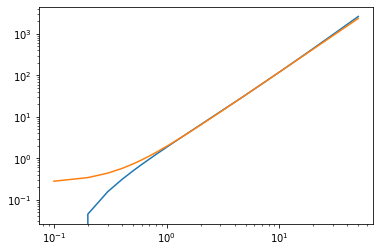

In [62]:
R = 0.1*(np.arange(500)+1)
plt.loglog(R,F)
plt.loglog(R,0.255931+1.69068*R**1.85164)
#plt.gca().set_ylim((0,500))
#plt.gca().set_xlim((0,20))
#plt.loglog(R,1.2*R**2)
plt.show()

In [56]:
params['wt']

array([0.2772748 , 1.28142609, 0.15770379, 0.78018186, 0.27876638,
       0.95694162])